### Try this notebook in Google Colab, Binder or SageMaker!


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/itk/SelectROI.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/InsightSoftwareConsortium/itkwidgets/HEAD?labpath=examples%2Fintegrations%2Fitk%2FSelectROI.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/itk/SelectROI.ipynb)

In [1]:
# Install dependencies for this example
import sys

!{sys.executable} -m pip install -q pooch tqdm "itk-io>=5.3.0" "itkwidgets[all]>=1.0a40"

In [1]:
import itk
import pooch
from ngff_zarr import to_multiscales, itk_image_to_ngff_image, to_ngff_image, Methods
from itkwidgets import view

In [2]:
file_name = pooch.retrieve('https://data.kitware.com/api/v1/file/564a5b078d777f7522dbfaa6/download',
                           fname='005_32months_T2_RegT1_Reg2Atlas_ManualBrainMask_Stripped.nrrd',
                           known_hash='a4a5739d5484f48653404763f807ff2b0e1900209cce029d912c2f92797207b6',
                           progressbar=True)

In [3]:
image = itk.imread(file_name)
ngff_image = itk_image_to_ngff_image(image)
multiscales = to_multiscales(ngff_image, method=Methods.DASK_IMAGE_GAUSSIAN)


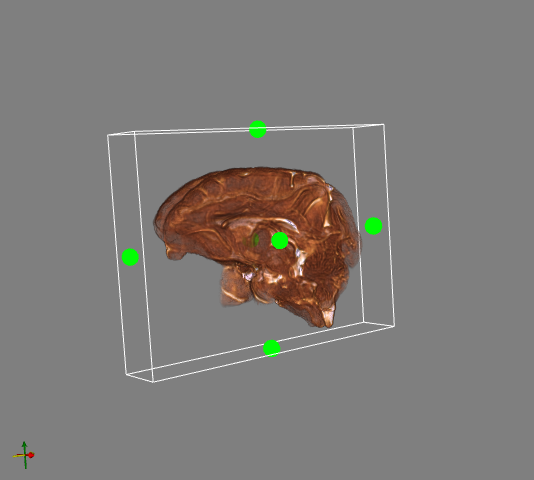
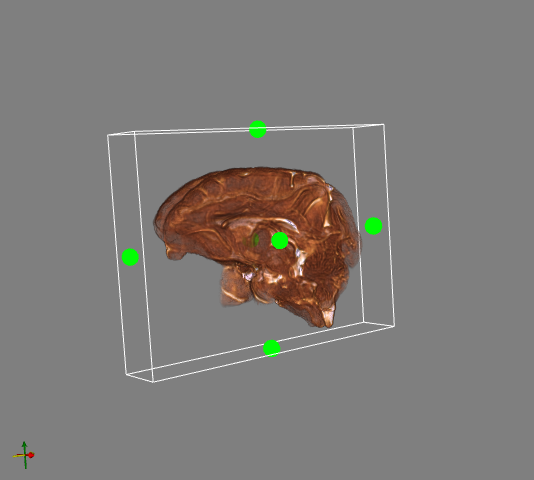

<IPython.core.display.Javascript object>

In [4]:
viewer = view(multiscales)

#### Use the cropping planes to select the region of interest, then run the following cells

<img src="https://raw.githubusercontent.com/InsightSoftwareConsortium/itkwidgets/main/examples/integrations/itk/select_roi.gif" style="margin:auto"/>

#### There will be one or more resolution scales available depending on the size of the data. The lower the scale the higher the resolution, with zero being the highest resolution.

In [5]:
# Find the scale that we currently have loaded
loaded_scale = viewer.get_current_scale()

In [6]:
loaded_scale

0

#### The ROI region will return the physical, world coordinates for the selection

In [7]:
# Get the selected region for the current level
roi_region = viewer.get_roi_region()

In [8]:
roi_region

[{'x': 25.592890941853682, 'y': -6.971699953079224, 'z': -6.971699953079224},
 {'x': 40.29312557391912, 'y': 88.71824049949645, 'z': 61.378257513046265}]

#### By default the information for the current scale is returned when requesting the ROI slices. You can also pass a value in to explicitly request a scale.

In [9]:
# Request the slice information for the ROI
default_roi_slices = viewer.get_roi_slice()
roi_slices = viewer.get_roi_slice(loaded_scale)

#### The results should match!
#### *Note*: The data is streamed in in chunks and the current resolution will improve as each scale becomes available. If you find that the slices do not match check the currently loaded scale (either programmatically or with the UI) - it may have improved since you last checked!

In [10]:
# The results should match
print(f'Slices for loaded scale:       {roi_slices}')
print(f'Slices with default parameter: {default_roi_slices}')

Slices for loaded scale:       (slice(0, 250, None), slice(0, 350, None), slice(118, 174, None))
Slices with default parameter: (slice(0, 250, None), slice(0, 350, None), slice(118, 174, None))


In [11]:
# Create a new viewer using only the data in the ROI determined above
loaded_image = multiscales.images[loaded_scale]
roi_data = loaded_image.data[roi_slices]
roi_image = to_ngff_image(
    roi_data,
    dims=loaded_image.dims,
    scale=loaded_image.scale,
    translation=roi_region[0])


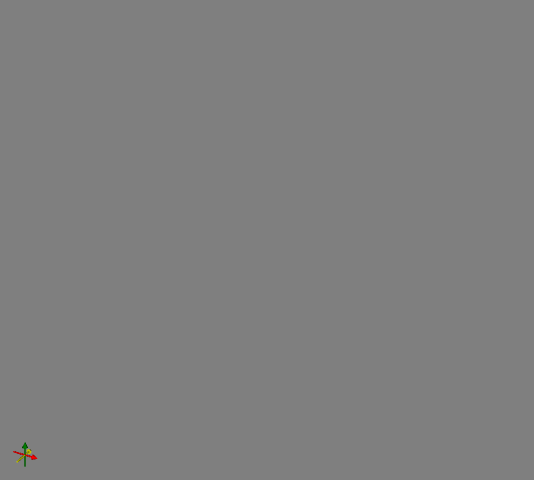
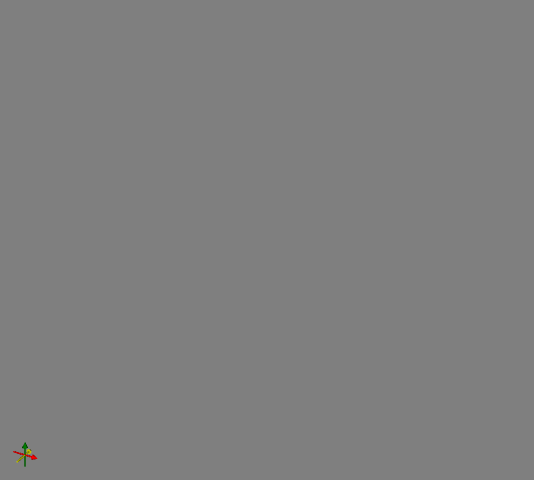

<IPython.core.display.Javascript object>

In [12]:
viewer2 = view(roi_image, rotate=True)

Extract the region from the original image.

Use physical units, which are independent of resolutions, slices.


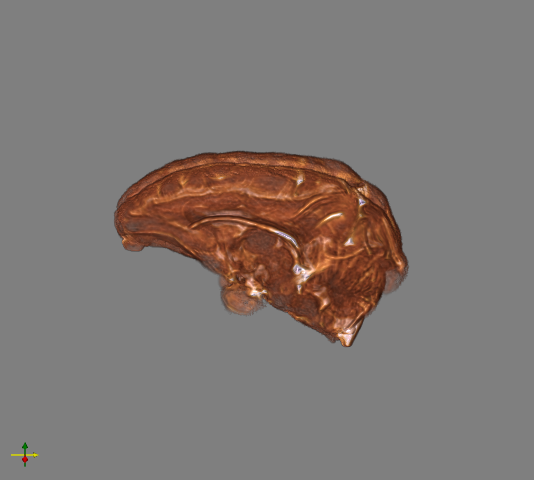
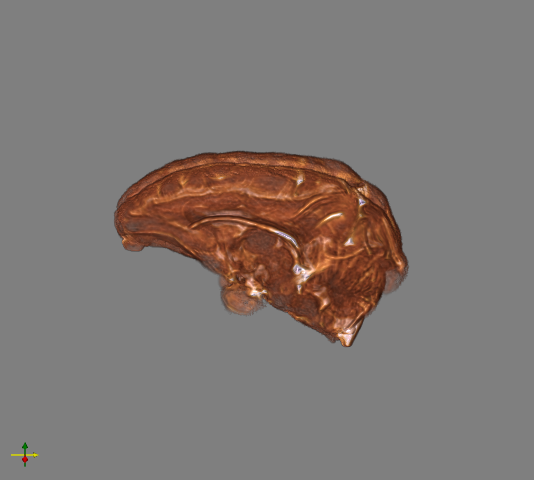

<IPython.core.display.Javascript object>

In [14]:
start_index = image.TransformPhysicalPointToIndex([roi_region[0]['x'], roi_region[0]['y'], roi_region[0]['z']])
size = image.TransformPhysicalPointToIndex([roi_region[1]['x'], roi_region[1]['y'], roi_region[1]['z']]) - start_index
extraction_region = itk.ImageRegion[3](start_index, size)

roi_image = itk.extract_image_filter(image, extraction_region=extraction_region)

viewer3 = view(roi_image, rotate=True)